# Satellite Imagery Classification

- objective
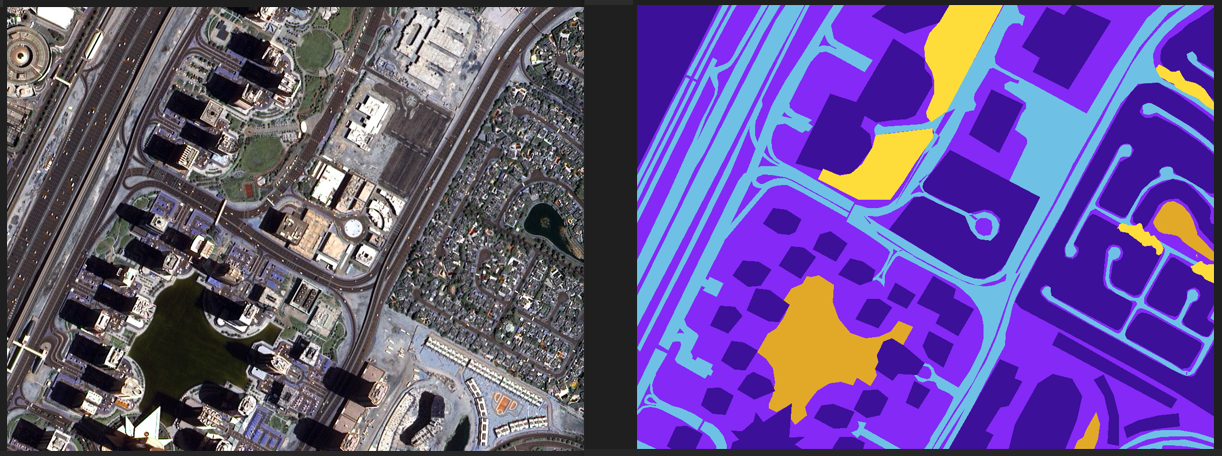
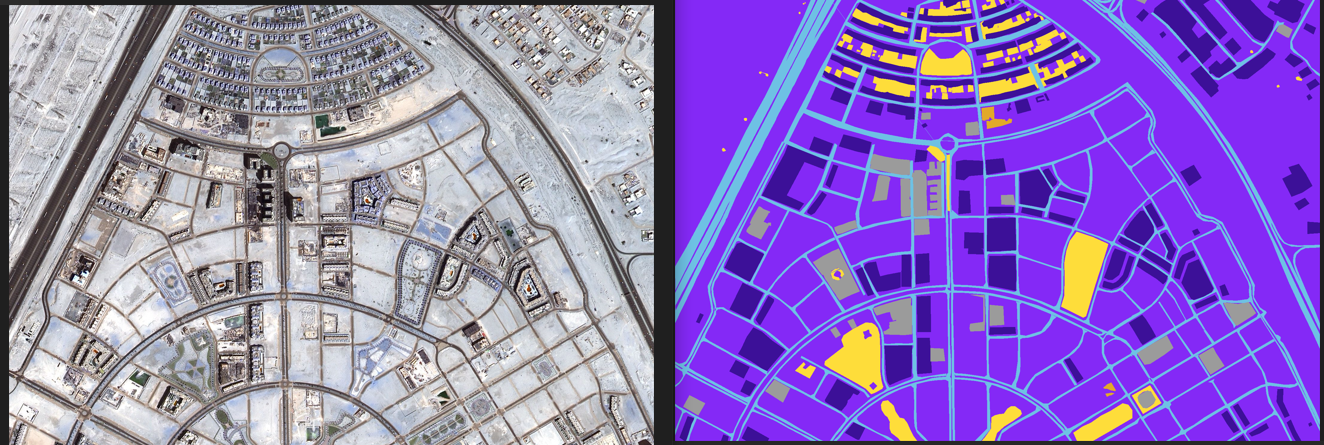

In [2]:
import os
import tensorflow as tf
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

# PART 1 data preprocessing

In [3]:
dataset_root_folder='dataset/'
dataset_name='dubai_dataset'

In [4]:
minmaxscalar=MinMaxScaler()

In [5]:
for path, subdir, files in os.walk(os.path.join(dataset_root_folder,dataset_name)):
    dir_name=path.split(os.path.sep)[-1]
    # print(dir_name)
    if dir_name == 'masks':
        images=os.listdir(path)
        # print(images)
        print(path)
        for i,image_name in enumerate(images):
            if (image_name.endswith('.png')): # mask image
                a=True
                # print(image_name)
    

dataset/dubai_dataset\Tile 1\masks
dataset/dubai_dataset\Tile 2\masks
dataset/dubai_dataset\Tile 3\masks
dataset/dubai_dataset\Tile 4\masks
dataset/dubai_dataset\Tile 5\masks
dataset/dubai_dataset\Tile 6\masks
dataset/dubai_dataset\Tile 7\masks
dataset/dubai_dataset\Tile 8\masks


In [6]:
# define patch size
image_patch_size=256

In [7]:
image=cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg',1)
image.shape

(544, 509, 3)

In [8]:
image_patches=patchify(image,(image_patch_size,image_patch_size,3),step=image_patch_size)

In [9]:
image_patches.shape

(2, 1, 1, 256, 256, 3)

In [10]:
imagex=image_patches[0,0,:,:]

imagey=minmaxscalar.fit_transform(imagex.reshape(-1,imagex.shape[-1])).reshape(imagex.shape)
imagey[0].shape

(256, 256, 3)

In [11]:
print(type(image))

<class 'numpy.ndarray'>


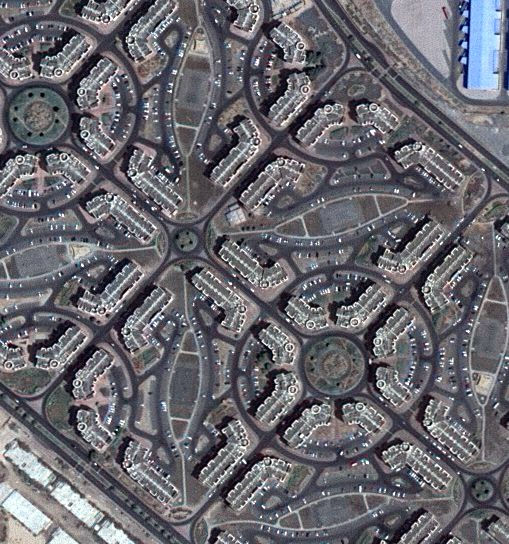

In [12]:
Image.fromarray(image)

In [13]:
(image.shape[0]//image_patch_size)*image_patch_size

512

# each image is of different shape

In [14]:
image_dataset=[]
mask_dataset=[]
 #png #jpg
for image_type in ['images','masks']:    #masks #images
    if image_type=='images':
        image_extension='jpg'
    elif image_type=='masks':
        image_extension='png'
    for tile_id in range(1,8):
        for image_id in range(1,20):
            image=cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
            if image is not None:

                if image_type=='masks':
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                # print(image.shape)
                size_x=(image.shape[1]//image_patch_size)*image_patch_size
                size_y=(image.shape[0]//image_patch_size)*image_patch_size
                # print('{}----{}-{}'.format(image.shape,size_x,size_y)) # multiples of 256
                image=Image.fromarray(image)
                image=image.crop((0,0,size_x,size_y))
                # print(f'{image.size[0]},{image.size[1]}')
                image=np.array(image)
                patched_images=patchify(image,(image_patch_size,image_patch_size,3),step=image_patch_size)
                # print(patched_images.shape)
                #get individual patched image
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        if image_type == 'images':
                            individual_patched_image=patched_images[i,j,:,:]
                            # print(individual_patched_image.shape)
                            individual_patched_image=minmaxscalar.fit_transform(individual_patched_image.reshape(-1,individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                            individual_patched_image=individual_patched_image[0]
                            # print(individual_patched_image.shape)
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask=patched_images[i,j,:,:]
                            individual_patched_mask=individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

In [15]:
image_dataset=np.array(image_dataset)
mask_dataset=np.array(mask_dataset)

In [16]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


# renderning the images

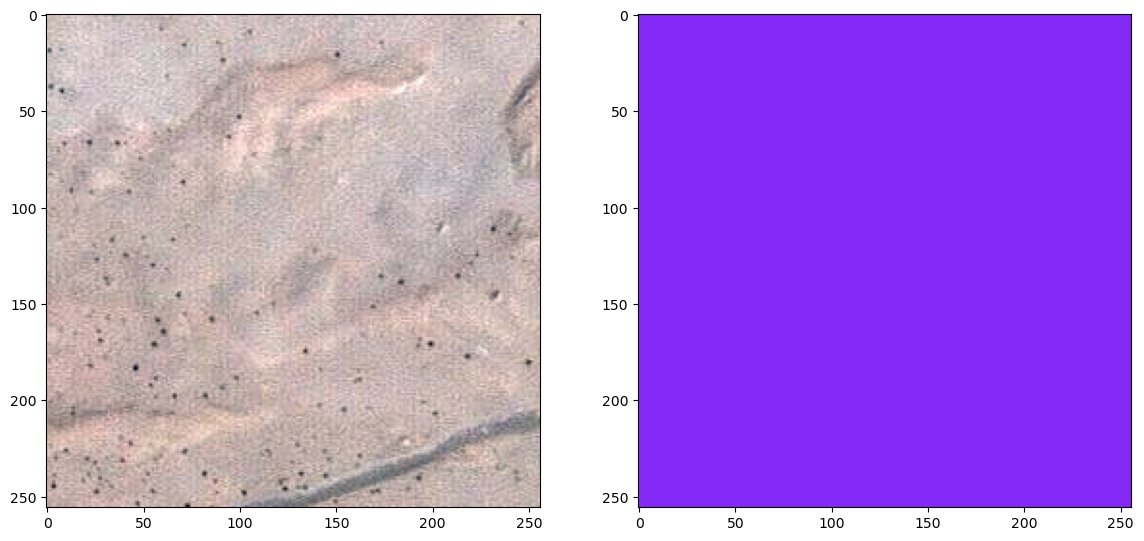

In [17]:
random_image_id=random.randint(0,len(image_dataset))
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

# Mask label processing
- color code to one-Hot encoding transformation
- after each image is transformed into
- 256x256x3 where 3 is RGB color code
- 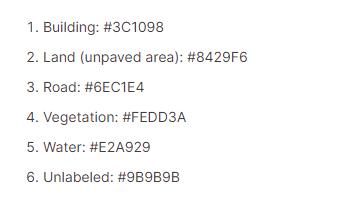

# python code to convert HEX value to RGB

In [18]:
class_building='#3C1098' # blue #green RGB
class_building=class_building.strip('#')
# 3C 10 98
class_building=np.array(tuple(int(class_building[i:i+2],16) for i in (0,2,4)))
print(class_building)

class_land='#8429F6' # purple #light green RGB
class_land=class_land.strip('#')
class_land=np.array(tuple(int(class_land[i:i+2],16) for i in (0,2,4)))
print(class_land)

class_road='#6EC1E4' # light blue #skin RGB
class_road=class_road.strip('#')
class_road=np.array(tuple(int(class_road[i:i+2],16) for i in (0,2,4)))
print(class_road)

class_vegetation='#FEDD3A' # yellow
class_vegetation=class_vegetation.strip('#')
class_vegetation=np.array(tuple(int(class_vegetation[i:i+2],16) for i in (0,2,4)))
print(class_vegetation)

class_water='#E2A929' # gold
class_water=class_water.strip('#')
class_water=np.array(tuple(int(class_water[i:i+2],16) for i in (0,2,4)))
print(class_water)

class_unlabeled='#9B9B9B' # silver
class_unlabeled=class_unlabeled.strip('#')
class_unlabeled=np.array(tuple(int(class_unlabeled[i:i+2],16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [19]:
mask_dataset.shape

(945, 256, 256, 3)

In [20]:
label=individual_patched_mask

In [21]:
def rgb_to_label(label):
    label_segment=np.zeros(label.shape,dtype=np.uint8)
    label_segment[np.all(label == class_water,axis=-1)]=0
    label_segment[np.all(label == class_land,axis=-1)]=1
    label_segment[np.all(label == class_road,axis=-1)]=2
    label_segment[np.all(label == class_building,axis=-1)]=3
    label_segment[np.all(label == class_vegetation,axis=-1)]=4
    label_segment[np.all(label == class_unlabeled,axis=-1)]=5
    label_segment=label_segment[:,:,0]
    return label_segment

In [22]:
# iterate mask dataset
labels=[]
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)
print(len(labels))

945


In [23]:
labels=np.array(labels)

In [24]:
labels[0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [25]:
labels=np.expand_dims(labels, axis=3)

In [26]:
# labels[0]

In [27]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

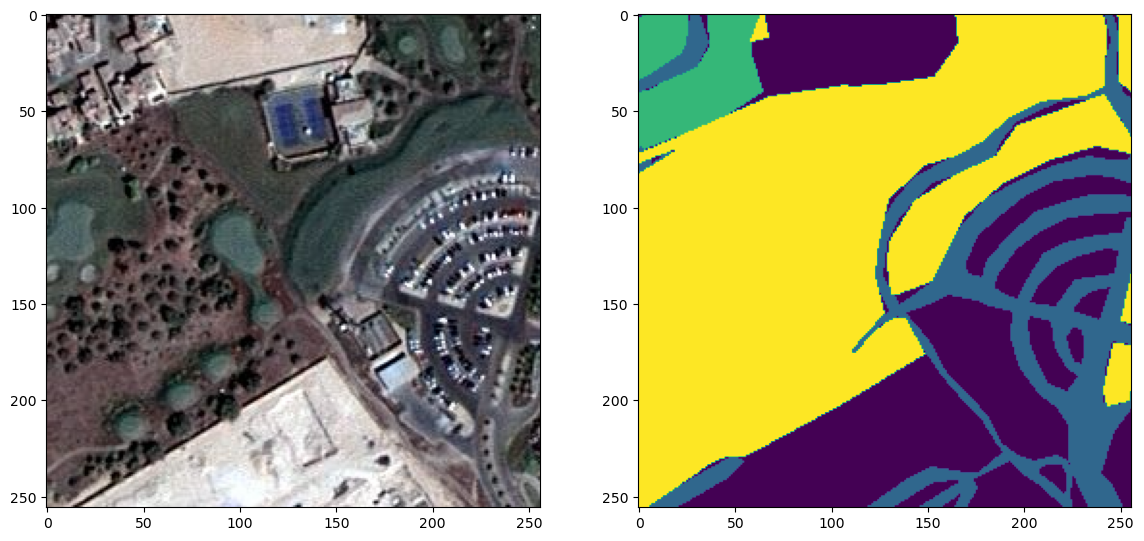

In [28]:
# render output based on labels 
random_image_id=random.randint(0,len(image_dataset))
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
# plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])
# print(labels[random_image_id])

# test and train dataset

In [29]:
master_training_dataset=image_dataset

In [30]:
total_classes=len(np.unique(labels))
total_classes

6

In [31]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [32]:
# create categorical variables 
labels_categorical_dataset=to_categorical(labels,num_classes=total_classes)

In [33]:
labels_categorical_dataset.shape,master_training_dataset.shape

((945, 256, 256, 6), (945, 256, 256, 3))

In [34]:
xtrain,xtest,ytrain,ytest=train_test_split(master_training_dataset,labels_categorical_dataset,test_size=0.15,random_state=100)

In [35]:
xtrain.shape,xtest.shape,ytrain.shape,ytest.shape

((803, 256, 256, 3),
 (142, 256, 256, 3),
 (803, 256, 256, 6),
 (142, 256, 256, 6))

In [36]:
image_height=xtrain.shape[1]
image_width=xtrain.shape[2]
image_channels=xtrain.shape[3]
total_classes=ytrain.shape[3]

In [37]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# PART 2 - modelling

- define layers
- evaluate layers
- jaccard Index/ intersection over union - evaluation matrics
- loss function - focal loss (cross entropy loss extension)
- diagnostics (plot loss)

In [38]:
from keras.models import Model
from keras.layers import Input,Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [39]:
from keras import backend as K # calculations - tensorflow

## evaluation metrics
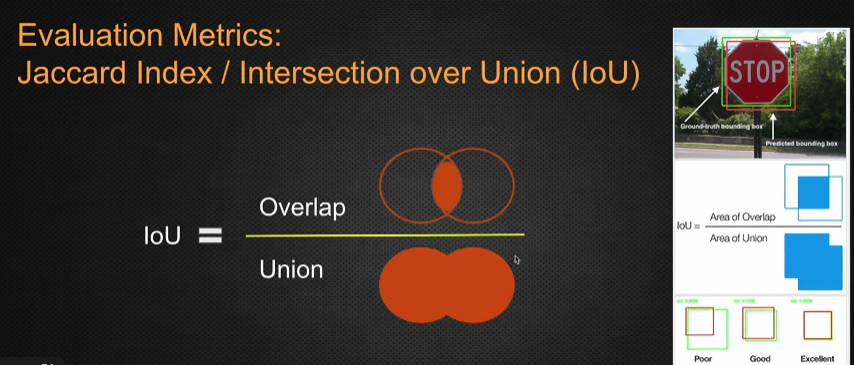

In [40]:
def jaccard_coeff(ytrue, ypred):
    ytrue_flatten=K.flatten(ytrue)
    ypred_flatten=K.flatten(ypred)
    intersection = K.sum(ytrue_flatten * ypred_flatten)
    final_coef_value=(intersection+1.0)/(K.sum(ytrue_flatten)+K.sum(ypred_flatten)-intersection+1.0)
    return final_coef_value

## u net architecture
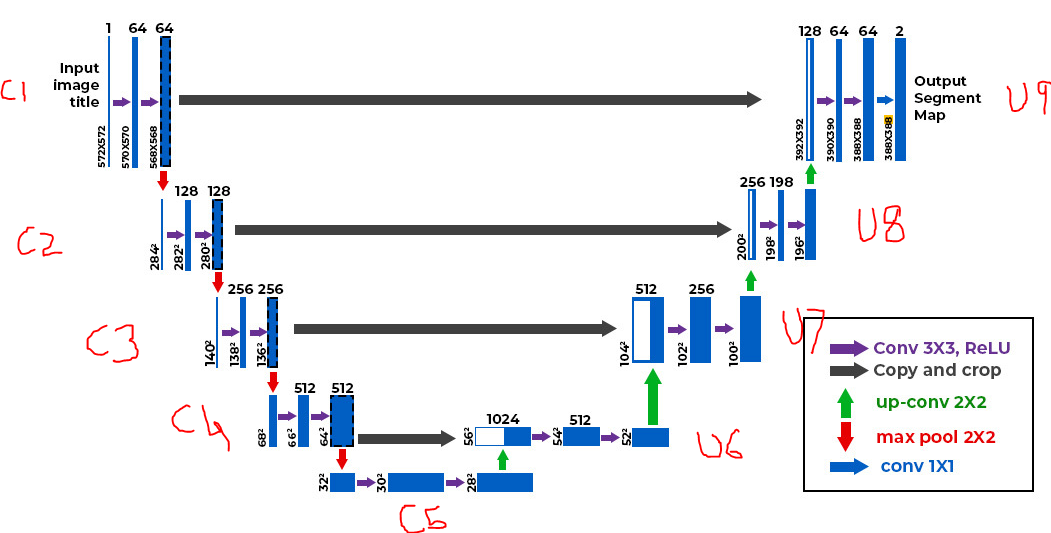

## netron - visualize any deep learning model 
- https://github.com/lutzroeder/netron

In [41]:
def multi_unet_model(n_classes=5,image_height=256,image_width=256,image_channels=1):

    inputs=Input((image_height,image_width,image_channels))
    source_input=inputs
    
    c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(source_input)
    c1=Dropout(0.2)(c1)
    c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
    p1=MaxPooling2D((2,2))(c1)

    c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
    c2=Dropout(0.2)(c2)
    c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
    p2=MaxPooling2D((2,2))(c2)

    c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
    c3=Dropout(0.2)(c3)
    c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
    p3=MaxPooling2D((2,2))(c3)

    c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
    c4=Dropout(0.2)(c4)
    c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
    p4=MaxPooling2D((2,2))(c4)

    c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
    c5=Dropout(0.2)(c5)
    c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)

    u6=Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
    u6=concatenate((u6,c4))
    c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
    c6=Dropout(0.2)(c6)
    c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

    u7=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
    u7=concatenate((u7,c3), axis=3)
    c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
    c7=Dropout(0.2)(c7)
    c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

    u8=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
    u8=concatenate((u8,c2))
    c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
    c8=Dropout(0.2)(c8)
    c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

    u9=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
    u9=concatenate((u9,c1))
    c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
    c9=Dropout(0.2)(c9)
    c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

    # output
    outputs=Conv2D(n_classes,(1,1),activation='softmax')(c9)
    model=Model(inputs=[inputs], outputs=[outputs])
    return model

In [42]:
metrics=['accuracy',jaccard_coeff]

In [43]:
def get_deep_learning_model():
    return multi_unet_model(
        n_classes=total_classes,
        image_height=image_height,
        image_width=image_width,
        image_channels=image_channels
    )

In [44]:
model=get_deep_learning_model()

In [45]:
model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'name': '

## Loss Function: Focal Loss (Cross Entropy Loss Extension)
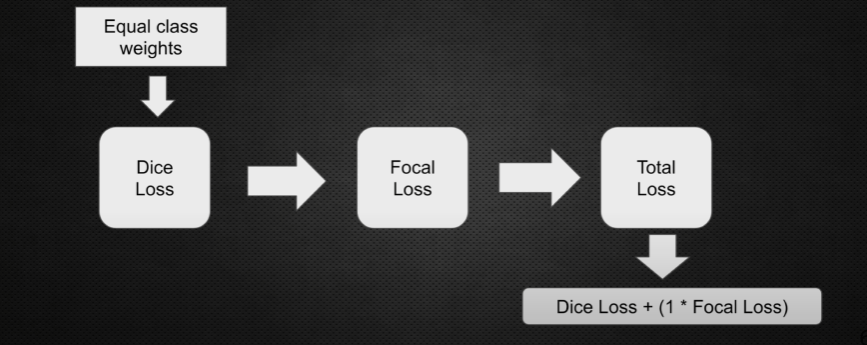

In [46]:
weights = [0.1666,0.1666,0.1666,0.1666,0.1666,0.1666]

# segmentation model
- https://github.com/qubvel/segmentation_models
- loss function to run during training

In [47]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [48]:
dice_loss=sm.losses.DiceLoss(class_weights=weights)
focal_loss=sm.losses.CategoricalFocalLoss()
total_loss=dice_loss+(1*focal_loss)

## model compilation

In [49]:
import tensorflow as tf

In [50]:
tf.keras.backend.clear_session()

In [51]:
model.compile(optimizer='adam',loss=total_loss,metrics=metrics)

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

##  to plot the model (Visualize)

In [53]:
from keras.utils.vis_utils import plot_model

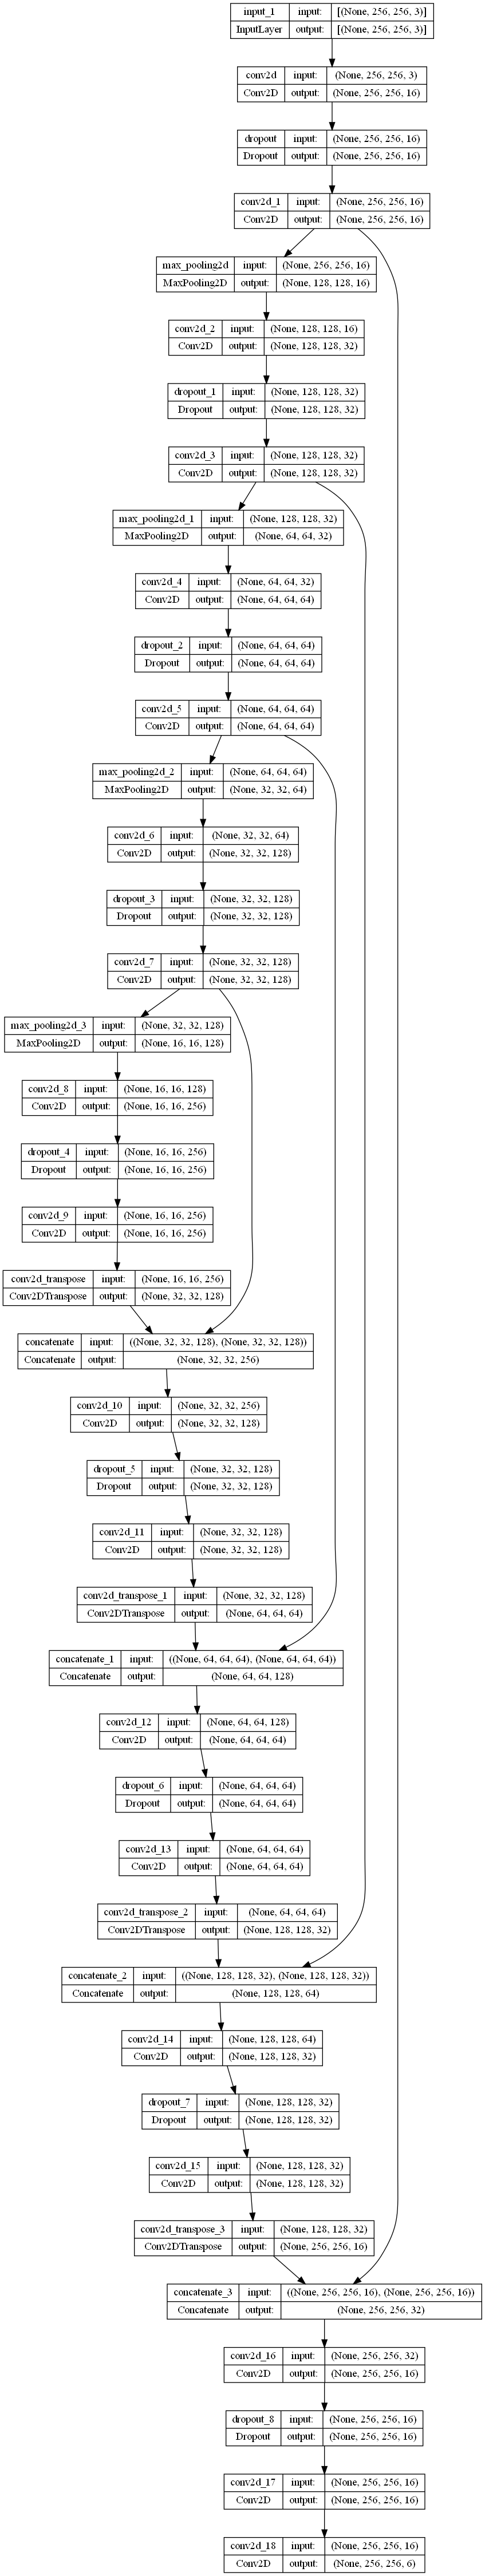

In [54]:
plot_model(model,to_file='satellite_model_plot.png',show_shapes=True,show_layer_names=True)

In [55]:
import keras
from IPython.display import clear_output
%matplotlib inline

In [56]:
class PlotLoss(keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.i=0
        self.x=[]
        self.losses=[]
        self.val_losses=[]
        self.jaccard_coef=[]
        self.val_jaccard_coef=[]
        self.fig=plt.figure()
        self.logs=[]
        
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.jaccard_coef.append(logs.get('jaccard_coeff'))
        self.val_jaccard_coef.append(logs.get('val_jaccard_coeff'))
        self.i +=1
        
        clear_output(wait=True)

        plt.plot(self.x,self.losses,label='loss')
        plt.plot(self.x,self.val_losses, label='val_loss')
        plt.plot(self.x,self.jaccard_coef,label='jaccard_coeff')
        plt.plot(self.x, self.val_jaccard_coef, label='val_jaccard_coeff')
        plt.legend()
        
        plt.show();

plot_loss=PlotLoss()

In [57]:
class PlotLossEx(keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.i=0
        self.x=[]
        self.losses=[]
        self.val_losses=[]
        self.jaccard_coef=[]
        self.val_jaccard_coef=[]
        self.fig=plt.figure()
        self.logs=[]
        
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.jaccard_coef.append(logs.get('jaccard_coeff'))
        self.val_jaccard_coef.append(logs.get('val_jaccard_coeff'))
        self.i +=1

        plt.figure(figsize=(14,8))
        f,(graph1,graph2)=plt.subplots(1,2,sharex=True)
        clear_output(wait=True)

        graph1.set_yscale('log')
        graph1.plot(self.x,self.losses,label='loss')
        graph1.plot(self.x, self.val_losses, label='val_loss')
        graph1.legend()

        graph2.set_yscale('log')
        graph2.plot(self.x,self.jaccard_coef,label='jaccard_coeff')
        graph2.plot(self.x, self.val_jaccard_coef, label='val_jaccard_coeff')
        graph2.legend()
        
        plt.show();

plot_loss=PlotLossEx()

## weights and biases callback function for run time diagnostics

In [61]:
import wandb
import os
from wandb.keras import WandbCallback


In [62]:
!wandb login f6696212866a9b097f6468d5cae2901364cf7713
# !export WANDB_INIT_TIMEOUT=120
# os.environ['WANDB_HTTP_TIMEOUT'] = '300'

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Anonymous\_netrc


In [63]:
!wandb status

Current Settings
{
  "_extra_http_headers": null,
  "_proxies": null,
  "api_key": null,
  "base_url": "https://api.wandb.ai",
  "entity": null,
  "git_remote": "origin",
  "ignore_globs": [],
  "project": null,
  "root_dir": null,
  "section": "default"
}


In [64]:
wandb.init(reinit=True,project='satellite-segmentation-dubai-images')


wandb: Currently logged in as: 26-amruth (26-amruth-immortalpi). Use `wandb login --relogin` to force relogin


In [65]:
# wandb.log({'accuracy':jaccard_coef, 'loss':total_loss})

In [66]:
wandb.config.dropout = 0.2

In [67]:
model_history=model.fit(xtrain,ytrain,
                        batch_size=16,
                        verbose=1,
                        epochs=100,
                        validation_data=(xtest,ytest),
                        shuffle=False,
                        # callbacks=[plot_loss] # exernal method for diagnostics local debigging
                        callbacks=[WandbCallback()] #remote debugging
                       )

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 0.9970 - accuracy: 0.5587 - jaccard_coeff: 0.2878

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 23s 270ms/step - loss: 0.9970 - accuracy: 0.5587 - jaccard_coeff: 0.2878 - val_loss: 0.9870 - val_accuracy: 0.6817 - val_jaccard_coeff: 0.3709
Epoch 2/100
50/51 [============================>.] - ETA: 0s - loss: 0.9791 - accuracy: 0.6923 - jaccard_coeff: 0.3841

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 220ms/step - loss: 0.9790 - accuracy: 0.6928 - jaccard_coeff: 0.3878 - val_loss: 0.9767 - val_accuracy: 0.7009 - val_jaccard_coeff: 0.3950
Epoch 3/100
50/51 [============================>.] - ETA: 0s - loss: 0.9595 - accuracy: 0.7337 - jaccard_coeff: 0.4690

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 12s 226ms/step - loss: 0.9595 - accuracy: 0.7341 - jaccard_coeff: 0.4718 - val_loss: 0.9657 - val_accuracy: 0.7098 - val_jaccard_coeff: 0.4494
Epoch 4/100
50/51 [============================>.] - ETA: 0s - loss: 0.9516 - accuracy: 0.7501 - jaccard_coeff: 0.5069

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 209ms/step - loss: 0.9516 - accuracy: 0.7506 - jaccard_coeff: 0.5085 - val_loss: 0.9643 - val_accuracy: 0.6956 - val_jaccard_coeff: 0.4454
Epoch 5/100
51/51 [==============================] - 6s 121ms/step - loss: 0.9447 - accuracy: 0.7713 - jaccard_coeff: 0.5482 - val_loss: 0.9733 - val_accuracy: 0.6875 - val_jaccard_coeff: 0.4670
Epoch 6/100
51/51 [==============================] - 6s 119ms/step - loss: 0.9411 - accuracy: 0.7796 - jaccard_coeff: 0.5642 - val_loss: 0.9669 - val_accuracy: 0.7112 - val_jaccard_coeff: 0.5037
Epoch 7/100
50/51 [============================>.] - ETA: 0s - loss: 0.9370 - accuracy: 0.7904 - jaccard_coeff: 0.5825

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 220ms/step - loss: 0.9370 - accuracy: 0.7909 - jaccard_coeff: 0.5855 - val_loss: 0.9561 - val_accuracy: 0.7505 - val_jaccard_coeff: 0.5482
Epoch 8/100
50/51 [============================>.] - ETA: 0s - loss: 0.9329 - accuracy: 0.8002 - jaccard_coeff: 0.6021

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 208ms/step - loss: 0.9330 - accuracy: 0.8006 - jaccard_coeff: 0.6050 - val_loss: 0.9508 - val_accuracy: 0.7659 - val_jaccard_coeff: 0.5693
Epoch 9/100
51/51 [==============================] - 6s 119ms/step - loss: 0.9303 - accuracy: 0.8092 - jaccard_coeff: 0.6182 - val_loss: 0.9544 - val_accuracy: 0.7571 - val_jaccard_coeff: 0.5679
Epoch 10/100
50/51 [============================>.] - ETA: 0s - loss: 0.9295 - accuracy: 0.8107 - jaccard_coeff: 0.6185

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 210ms/step - loss: 0.9295 - accuracy: 0.8111 - jaccard_coeff: 0.6207 - val_loss: 0.9424 - val_accuracy: 0.7794 - val_jaccard_coeff: 0.5888
Epoch 11/100
51/51 [==============================] - 7s 125ms/step - loss: 0.9258 - accuracy: 0.8211 - jaccard_coeff: 0.6375 - val_loss: 0.9444 - val_accuracy: 0.7791 - val_jaccard_coeff: 0.5977
Epoch 12/100
50/51 [============================>.] - ETA: 0s - loss: 0.9249 - accuracy: 0.8227 - jaccard_coeff: 0.6376

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 217ms/step - loss: 0.9249 - accuracy: 0.8230 - jaccard_coeff: 0.6399 - val_loss: 0.9389 - val_accuracy: 0.7885 - val_jaccard_coeff: 0.6064
Epoch 13/100
50/51 [============================>.] - ETA: 0s - loss: 0.9226 - accuracy: 0.8288 - jaccard_coeff: 0.6490

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 215ms/step - loss: 0.9226 - accuracy: 0.8291 - jaccard_coeff: 0.6513 - val_loss: 0.9366 - val_accuracy: 0.7908 - val_jaccard_coeff: 0.6143
Epoch 14/100
50/51 [============================>.] - ETA: 0s - loss: 0.9203 - accuracy: 0.8329 - jaccard_coeff: 0.6579

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 208ms/step - loss: 0.9203 - accuracy: 0.8332 - jaccard_coeff: 0.6603 - val_loss: 0.9326 - val_accuracy: 0.8034 - val_jaccard_coeff: 0.6337
Epoch 15/100
51/51 [==============================] - 6s 120ms/step - loss: 0.9190 - accuracy: 0.8373 - jaccard_coeff: 0.6659 - val_loss: 0.9358 - val_accuracy: 0.7990 - val_jaccard_coeff: 0.6266
Epoch 16/100
51/51 [==============================] - 6s 121ms/step - loss: 0.9199 - accuracy: 0.8339 - jaccard_coeff: 0.6594 - val_loss: 0.9367 - val_accuracy: 0.7976 - val_jaccard_coeff: 0.6214
Epoch 17/100
51/51 [==============================] - 6s 122ms/step - loss: 0.9197 - accuracy: 0.8360 - jaccard_coeff: 0.6628 - val_loss: 0.9343 - val_accuracy: 0.7976 - val_jaccard_coeff: 0.6138
Epoch 18/100
50/51 [============================>.] - ETA: 0s - loss: 0.9175 - accuracy: 0.8399 - jaccard_coeff: 0.6670

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 217ms/step - loss: 0.9175 - accuracy: 0.8402 - jaccard_coeff: 0.6697 - val_loss: 0.9303 - val_accuracy: 0.8102 - val_jaccard_coeff: 0.6378
Epoch 19/100
51/51 [==============================] - 7s 124ms/step - loss: 0.9157 - accuracy: 0.8459 - jaccard_coeff: 0.6806 - val_loss: 0.9306 - val_accuracy: 0.8118 - val_jaccard_coeff: 0.6407
Epoch 20/100
50/51 [============================>.] - ETA: 0s - loss: 0.9151 - accuracy: 0.8464 - jaccard_coeff: 0.6793

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 210ms/step - loss: 0.9152 - accuracy: 0.8467 - jaccard_coeff: 0.6817 - val_loss: 0.9287 - val_accuracy: 0.8155 - val_jaccard_coeff: 0.6519
Epoch 21/100
50/51 [============================>.] - ETA: 0s - loss: 0.9134 - accuracy: 0.8514 - jaccard_coeff: 0.6865

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 206ms/step - loss: 0.9134 - accuracy: 0.8517 - jaccard_coeff: 0.6885 - val_loss: 0.9281 - val_accuracy: 0.8149 - val_jaccard_coeff: 0.6463
Epoch 22/100
51/51 [==============================] - 7s 128ms/step - loss: 0.9134 - accuracy: 0.8527 - jaccard_coeff: 0.6899 - val_loss: 0.9296 - val_accuracy: 0.8097 - val_jaccard_coeff: 0.6414
Epoch 23/100
50/51 [============================>.] - ETA: 0s - loss: 0.9124 - accuracy: 0.8545 - jaccard_coeff: 0.6921

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 219ms/step - loss: 0.9124 - accuracy: 0.8548 - jaccard_coeff: 0.6945 - val_loss: 0.9232 - val_accuracy: 0.8277 - val_jaccard_coeff: 0.6625
Epoch 24/100
50/51 [============================>.] - ETA: 0s - loss: 0.9104 - accuracy: 0.8598 - jaccard_coeff: 0.7010

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 210ms/step - loss: 0.9104 - accuracy: 0.8601 - jaccard_coeff: 0.7032 - val_loss: 0.9229 - val_accuracy: 0.8296 - val_jaccard_coeff: 0.6685
Epoch 25/100
51/51 [==============================] - 6s 123ms/step - loss: 0.9102 - accuracy: 0.8605 - jaccard_coeff: 0.7035 - val_loss: 0.9393 - val_accuracy: 0.7951 - val_jaccard_coeff: 0.6269
Epoch 26/100
51/51 [==============================] - 6s 124ms/step - loss: 0.9140 - accuracy: 0.8516 - jaccard_coeff: 0.6854 - val_loss: 0.9324 - val_accuracy: 0.8053 - val_jaccard_coeff: 0.6385
Epoch 27/100
51/51 [==============================] - 6s 126ms/step - loss: 0.9108 - accuracy: 0.8590 - jaccard_coeff: 0.7014 - val_loss: 0.9248 - val_accuracy: 0.8268 - val_jaccard_coeff: 0.6675
Epoch 28/100
50/51 [============================>.] - ETA: 0s - loss: 0.9089 - accuracy: 0.8640 - jaccard_coeff: 0.7092

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 208ms/step - loss: 0.9089 - accuracy: 0.8643 - jaccard_coeff: 0.7116 - val_loss: 0.9206 - val_accuracy: 0.8358 - val_jaccard_coeff: 0.6775
Epoch 29/100
50/51 [============================>.] - ETA: 0s - loss: 0.9074 - accuracy: 0.8679 - jaccard_coeff: 0.7142

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 216ms/step - loss: 0.9074 - accuracy: 0.8683 - jaccard_coeff: 0.7165 - val_loss: 0.9192 - val_accuracy: 0.8412 - val_jaccard_coeff: 0.6866
Epoch 30/100
50/51 [============================>.] - ETA: 0s - loss: 0.9067 - accuracy: 0.8705 - jaccard_coeff: 0.7173

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 215ms/step - loss: 0.9068 - accuracy: 0.8708 - jaccard_coeff: 0.7193 - val_loss: 0.9187 - val_accuracy: 0.8410 - val_jaccard_coeff: 0.6894
Epoch 31/100
51/51 [==============================] - 6s 122ms/step - loss: 0.9101 - accuracy: 0.8633 - jaccard_coeff: 0.7057 - val_loss: 0.9217 - val_accuracy: 0.8329 - val_jaccard_coeff: 0.6749
Epoch 32/100
51/51 [==============================] - 6s 124ms/step - loss: 0.9095 - accuracy: 0.8637 - jaccard_coeff: 0.7088 - val_loss: 0.9208 - val_accuracy: 0.8342 - val_jaccard_coeff: 0.6772
Epoch 33/100
51/51 [==============================] - 6s 119ms/step - loss: 0.9064 - accuracy: 0.8715 - jaccard_coeff: 0.7223 - val_loss: 0.9202 - val_accuracy: 0.8391 - val_jaccard_coeff: 0.6836
Epoch 34/100
51/51 [==============================] - 6s 119ms/step - loss: 0.9114 - accuracy: 0.8586 - jaccard_coeff: 0.6993 - val_loss: 0.9451 - val_accuracy: 0.7641 - val_jaccard_coeff: 0.5612
Epoch 35/100
51/51 [============

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 209ms/step - loss: 0.9050 - accuracy: 0.8753 - jaccard_coeff: 0.7297 - val_loss: 0.9181 - val_accuracy: 0.8452 - val_jaccard_coeff: 0.6972
Epoch 38/100
50/51 [============================>.] - ETA: 0s - loss: 0.9036 - accuracy: 0.8787 - jaccard_coeff: 0.7322

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 207ms/step - loss: 0.9036 - accuracy: 0.8789 - jaccard_coeff: 0.7345 - val_loss: 0.9159 - val_accuracy: 0.8510 - val_jaccard_coeff: 0.7088
Epoch 39/100
51/51 [==============================] - 7s 123ms/step - loss: 0.9024 - accuracy: 0.8813 - jaccard_coeff: 0.7394 - val_loss: 0.9159 - val_accuracy: 0.8509 - val_jaccard_coeff: 0.7116
Epoch 40/100
51/51 [==============================] - 7s 129ms/step - loss: 0.9021 - accuracy: 0.8818 - jaccard_coeff: 0.7402 - val_loss: 0.9166 - val_accuracy: 0.8479 - val_jaccard_coeff: 0.7017
Epoch 41/100
51/51 [==============================] - 6s 120ms/step - loss: 0.9015 - accuracy: 0.8827 - jaccard_coeff: 0.7429 - val_loss: 0.9176 - val_accuracy: 0.8443 - val_jaccard_coeff: 0.6960
Epoch 42/100
51/51 [==============================] - 6s 119ms/step - loss: 0.9012 - accuracy: 0.8822 - jaccard_coeff: 0.7434 - val_loss: 0.9213 - val_accuracy: 0.8357 - val_jaccard_coeff: 0.6887
Epoch 43/100
51/51 [============

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 210ms/step - loss: 0.8997 - accuracy: 0.8831 - jaccard_coeff: 0.7530 - val_loss: 0.9152 - val_accuracy: 0.8497 - val_jaccard_coeff: 0.7125
Epoch 46/100
50/51 [============================>.] - ETA: 0s - loss: 0.8993 - accuracy: 0.8851 - jaccard_coeff: 0.7545

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 206ms/step - loss: 0.8994 - accuracy: 0.8854 - jaccard_coeff: 0.7569 - val_loss: 0.9126 - val_accuracy: 0.8581 - val_jaccard_coeff: 0.7260
Epoch 47/100
50/51 [============================>.] - ETA: 0s - loss: 0.8977 - accuracy: 0.8880 - jaccard_coeff: 0.7607

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 213ms/step - loss: 0.8978 - accuracy: 0.8882 - jaccard_coeff: 0.7628 - val_loss: 0.9111 - val_accuracy: 0.8586 - val_jaccard_coeff: 0.7263
Epoch 48/100
51/51 [==============================] - 6s 120ms/step - loss: 0.8979 - accuracy: 0.8870 - jaccard_coeff: 0.7617 - val_loss: 0.9172 - val_accuracy: 0.8441 - val_jaccard_coeff: 0.7029
Epoch 49/100
51/51 [==============================] - 6s 119ms/step - loss: 0.9014 - accuracy: 0.8801 - jaccard_coeff: 0.7496 - val_loss: 0.9133 - val_accuracy: 0.8500 - val_jaccard_coeff: 0.7072
Epoch 50/100
51/51 [==============================] - 6s 121ms/step - loss: 0.9011 - accuracy: 0.8801 - jaccard_coeff: 0.7491 - val_loss: 0.9140 - val_accuracy: 0.8515 - val_jaccard_coeff: 0.7140
Epoch 51/100
51/51 [==============================] - 6s 120ms/step - loss: 0.8976 - accuracy: 0.8861 - jaccard_coeff: 0.7605 - val_loss: 0.9127 - val_accuracy: 0.8545 - val_jaccard_coeff: 0.7225
Epoch 52/100
51/51 [============

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_072602-g3x3r234\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 215ms/step - loss: 0.8932 - accuracy: 0.8910 - jaccard_coeff: 0.7704 - val_loss: 0.9067 - val_accuracy: 0.8671 - val_jaccard_coeff: 0.7421
Epoch 64/100
51/51 [==============================] - 7s 127ms/step - loss: 0.8930 - accuracy: 0.8911 - jaccard_coeff: 0.7703 - val_loss: 0.9186 - val_accuracy: 0.8414 - val_jaccard_coeff: 0.7044
Epoch 65/100
51/51 [==============================] - 7s 133ms/step - loss: 0.8912 - accuracy: 0.8899 - jaccard_coeff: 0.7682 - val_loss: 0.9117 - val_accuracy: 0.8551 - val_jaccard_coeff: 0.7274
Epoch 66/100
51/51 [==============================] - 7s 131ms/step - loss: 0.8895 - accuracy: 0.8944 - jaccard_coeff: 0.7776 - val_loss: 0.9244 - val_accuracy: 0.8283 - val_jaccard_coeff: 0.6819
Epoch 67/100
51/51 [==============================] - 7s 130ms/step - loss: 0.8918 - accuracy: 0.8905 - jaccard_coeff: 0.7687 - val_loss: 0.9148 - val_accuracy: 0.8506 - val_jaccard_coeff: 0.7138
Epoch 68/100
51/51 [============

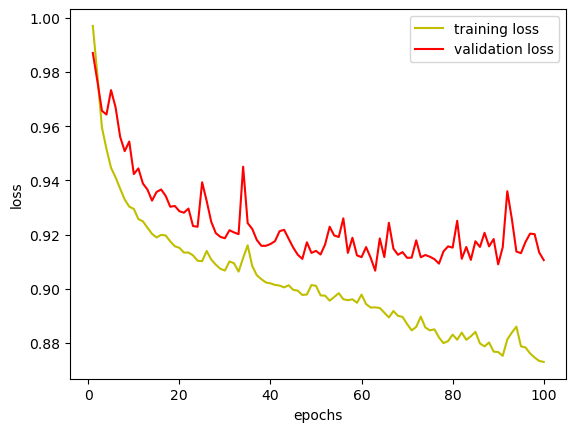

In [68]:
history_a=model_history
loss=history_a.history['loss']
val_loss=history_a.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='training loss')
plt.plot(epochs,val_loss,'r',label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [69]:
# history_a.history

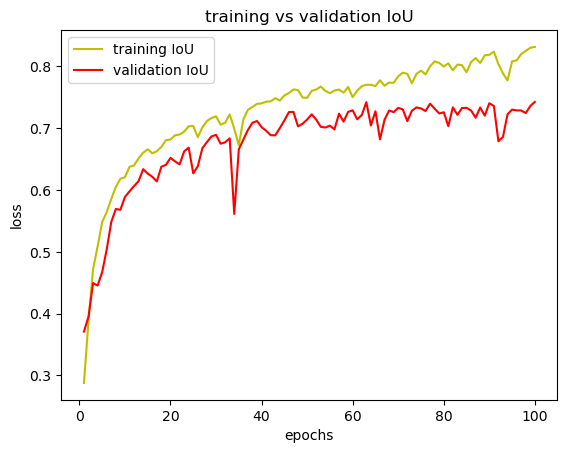

In [70]:
jaccard_coef=history_a.history['jaccard_coeff']
val_jaccard_coef=history_a.history['val_jaccard_coeff']
epochs=range(1,len(jaccard_coef)+1)
plt.plot(epochs,jaccard_coef,'y',label='training IoU')
plt.plot(epochs,val_jaccard_coef,'r',label='validation IoU')
plt.title('training vs validation IoU')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [71]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 51}

# perform predictions

In [72]:
y_pred=model.predict(xtest)

5/5 [==============================] - 2s 43ms/step


In [73]:
len(y_pred)

142

In [74]:
y_pred_argmax=np.argmax(y_pred,axis=3)

In [75]:
len(y_pred_argmax)

142

In [76]:
y_test_argmax=np.argmax(ytest,axis=3)

In [77]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

# comparing prediction results

In [82]:
test_image_number=random.randint(0,len(xtest))
test_image=xtest[test_image_number]
ground_truth_image=y_test_argmax[test_image_number]

test_image_input=np.expand_dims(test_image,0)

prediction=model.predict(test_image_input)
predicted_image=np.argmax(prediction,axis=3)
predicted_image=predicted_image[0,:,:]

1/1 [==============================] - 0s 22ms/step


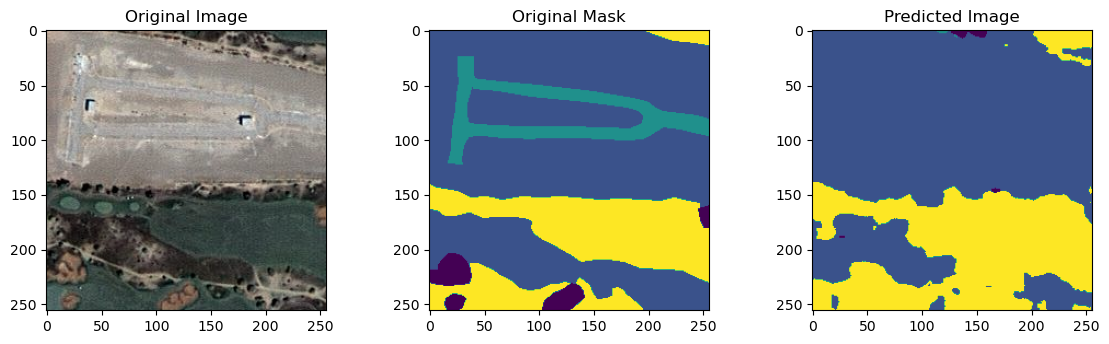

In [83]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(test_image)
plt.subplot(232)
plt.title('Original Mask')
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title('Predicted Image')
plt.imshow(predicted_image)

In [80]:
model.save('satellite_segmentation_full.h5')

# can visualize the model using netron by uploading the model
- https://netron.app/

# weights and biases runtime environment

In [81]:
# !wandb login f6696212866a9b097f6468d5cae2901364cf7713

# Load the saved model to perform prediction

In [84]:
from keras.models import load_model

In [90]:
saved_model=load_model('satellite_segmentation_full.h5',custom_objects=({'dice_loss_plus_1focal_loss':total_loss,'jaccard_coeff':jaccard_coeff}))

In [87]:
model.loss.name

'dice_loss_plus_1focal_loss'

In [92]:
saved_model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'name': '

In [93]:
test_image_number=random.randint(0,len(xtest))
test_image=xtest[test_image_number]
ground_truth_image=y_test_argmax[test_image_number]

test_image_input=np.expand_dims(test_image,0)

prediction=saved_model.predict(test_image_input)
predicted_image=np.argmax(prediction,axis=3)
predicted_image=predicted_image[0,:,:]

1/1 [==============================] - 0s 200ms/step


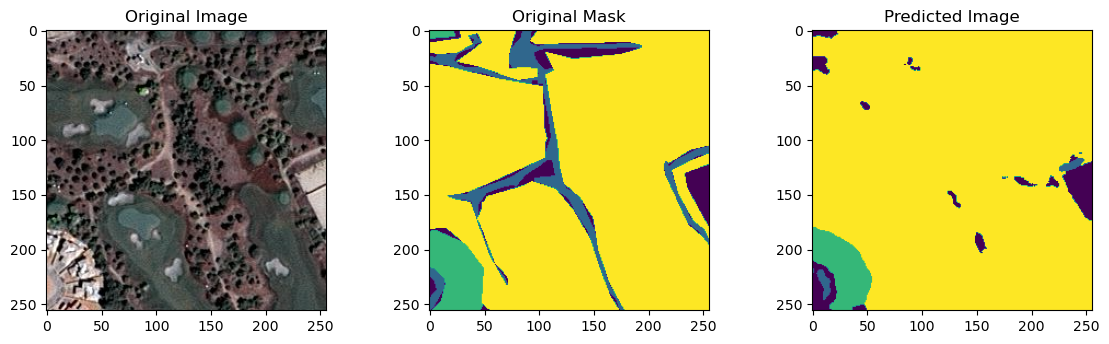

In [94]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(test_image)
plt.subplot(232)
plt.title('Original Mask')
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title('Predicted Image')
plt.imshow(predicted_image)

# predict using custom image from Google Map

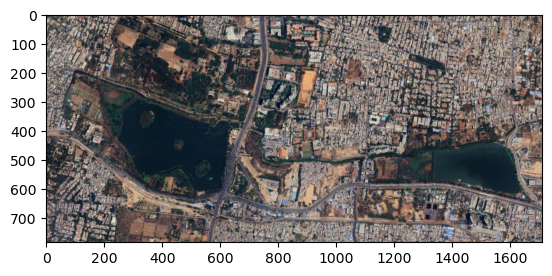

In [95]:
plt.imshow(Image.open('dataset/customImages/1.PNG'))

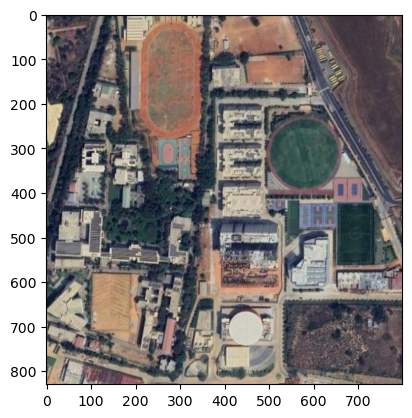

In [143]:
plt.imshow(Image.open('dataset/customImages/3.jpg'))

In [164]:
image=Image.open('dataset/customImages/7.jpg')
if image.mode == 'RGBA':
    image = image.convert('RGB')
image=image.resize((256,256))
# plt.imshow(image)
image=np.array(image)
image=np.expand_dims(image,0)

In [165]:
prediction=saved_model.predict(image)

1/1 [==============================] - 0s 22ms/step


In [166]:
predicted_image=np.argmax(prediction,axis=3)
predicted_image=predicted_image[0,:,:]

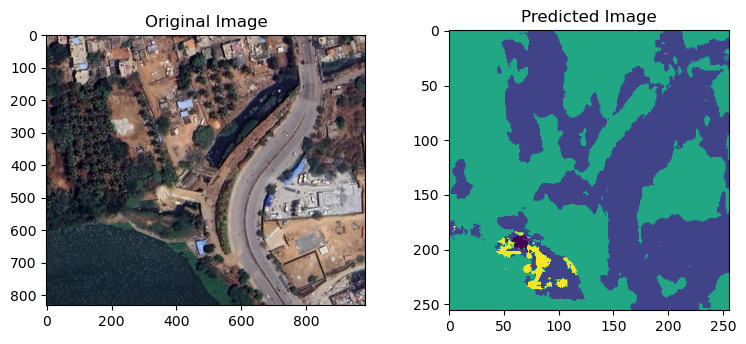

In [167]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(Image.open('dataset/customImages/7.jpg'))
plt.subplot(232)
plt.title('Predicted Image')
plt.imshow(predicted_image)